# 1. Классификация предметов одежды (датасет Fashion MNIST)


### Импорт библиотек

In [1]:
!set KMP_DUPLICATE_LIB_OK = True
import torchvision

In [2]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns



### Фукнция обучения модели 

In [87]:
def train(model, optimizer, criterion, n_epochs, train_loader, test_loader):
    
    loss_train = []
    accuracy_train = []

    for epoch in range(n_epochs):
        model.train()  # для трейна модели ставим ее в train() 
        for i, (images, labels) in enumerate(train_loader):
            if i % 5 == 0:  
                print('Батч', i)
            output = model(images)
            loss = criterion(output, labels)
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        model.eval()  # для теста модели ставим ее в eval()
        
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                output = model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = correct / total
        accuracy_train.append(test_accuracy)
        
        print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch, n_epochs, loss.item(), test_accuracy * 100))
        loss_train.append(loss.item())


In [4]:
# def train(model, optimizer, criterion, n_epochs):
    
#     loss_train = []
#     accuracy_train = []

#     for epoch in range(n_epochs):
#         model.train()  # для трейна модели ставим ее в train() 
#         for batch_id, (image, label) in enumerate(train_loader):
#             print(image.size())
#             image = image.view(image.shape[0], -1)
#             print(image.size())

#             output = model(image)
#             loss = criterion(output, label)
    
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
    
#         model.eval()  # для теста модели ставим ее в eval()
        
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for image, label in test_loader:
#                 image = image.view(image.shape[0], -1)
#                 output = model(image)
#                 _, predicted = torch.max(output.data, 1)
#                 total += label.size(0)
#                 correct += (predicted == label).sum().item()
        
#         test_accuracy = correct / total
#         accuracy_train.append(test_accuracy)
        
#         print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch, 20, loss.item(), test_accuracy * 100))
#         loss_train.append(loss.item())



## 1.1 Решить задачу классификации, не используя сверточные слои. 
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

### Архитектура модели 

In [5]:
# Параметры модели:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

### Загрузка данных

In [6]:
# обязательно используем shuffle так как у нашего датасет есть порядок
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST(root="./data/", train=True, download=True,
                             transform=
                               torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST(root="./data/", train=False, download=True,
                             transform=
                               torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

### Анализ датасета

In [7]:
print("Количество примеров в обучающем наборе данных:",  len(train_loader.dataset))
print("Количество примеров в тестовом наборе данных:", len(test_loader.dataset))


Количество примеров в обучающем наборе данных: 60000
Количество примеров в тестовом наборе данных: 10000


In [8]:
print("Количество batch в обучающем наборе данных:",  len(train_loader))
print("Количество batch в тестовом наборе данных:", len(test_loader))

Количество batch в обучающем наборе данных: 938
Количество batch в тестовом наборе данных: 157


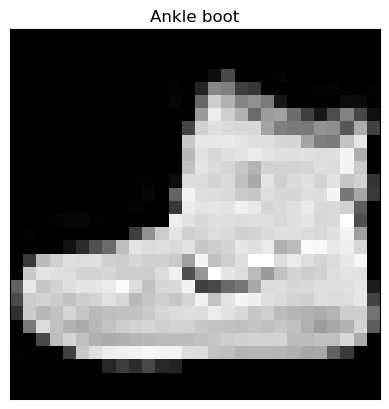

In [9]:
image, label = train_loader.dataset[0]
# Отобразите изображение
plt.tight_layout()
plt.imshow(image.squeeze(), cmap='gray', interpolation='none')
plt.title(train_loader.dataset.classes[label])
plt.xticks([])
plt.yticks([])
plt.show()

In [10]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

Параметры batch. Размер batch, цвет, W, H.

In [11]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape



torch.Size([64, 1, 28, 28])

Все классы

In [12]:
test_loader.dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Больше примеров

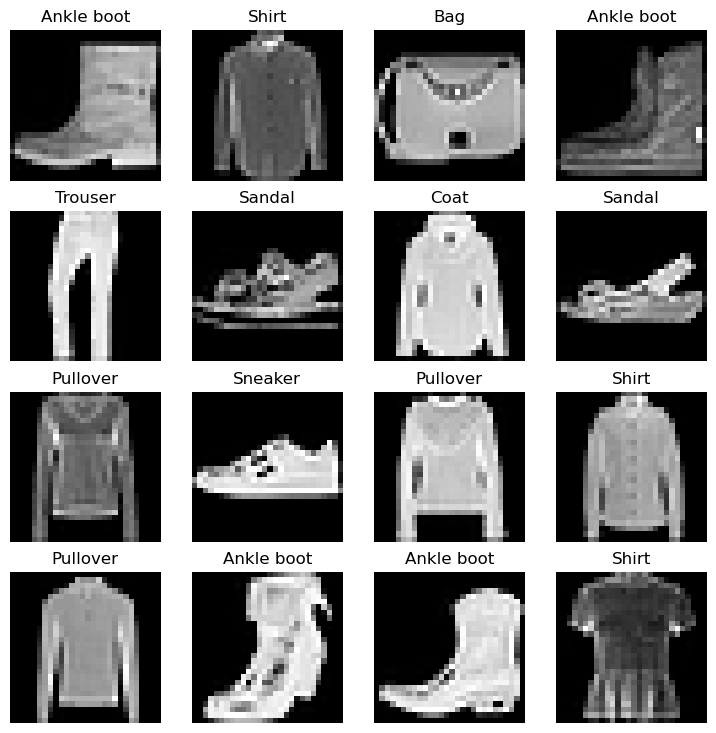

In [13]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_loader.dataset), size=[1]).item()
    img, label = train_loader.dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_loader.dataset.classes[label])
    plt.axis(False);

### Модель

In [14]:
class FashionMNIST(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], num_classes)
    def forward(self, x):
        x = x.view(x.shape[0],-1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out
    

#### Количество параметров модели

In [15]:
model = FashionMNIST(784, [150, 150, 150], 10)
print('Количество параметров модели: ', sum(p.numel() for p in model.parameters()))

Количество параметров модели:  164560


#### Обчуние модели 

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train(model, optimizer, criterion, n_epochs, train_loader, test_loader)

Epoch [0/20], Loss: 0.3016, Test Accuracy: 84.07%
Epoch [1/20], Loss: 0.3144, Test Accuracy: 86.02%
Epoch [2/20], Loss: 0.4359, Test Accuracy: 86.57%
Epoch [3/20], Loss: 0.3599, Test Accuracy: 86.74%
Epoch [4/20], Loss: 0.2445, Test Accuracy: 87.63%
Epoch [5/20], Loss: 0.2815, Test Accuracy: 87.69%
Epoch [6/20], Loss: 0.2032, Test Accuracy: 88.13%
Epoch [7/20], Loss: 0.3010, Test Accuracy: 88.75%
Epoch [8/20], Loss: 0.1800, Test Accuracy: 87.87%
Epoch [9/20], Loss: 0.2555, Test Accuracy: 87.95%
Epoch [10/20], Loss: 0.0527, Test Accuracy: 88.31%
Epoch [11/20], Loss: 0.3892, Test Accuracy: 88.42%
Epoch [12/20], Loss: 0.1480, Test Accuracy: 89.11%
Epoch [13/20], Loss: 0.0838, Test Accuracy: 88.65%
Epoch [14/20], Loss: 0.0766, Test Accuracy: 88.35%
Epoch [15/20], Loss: 0.1269, Test Accuracy: 88.72%
Epoch [16/20], Loss: 0.1990, Test Accuracy: 88.98%
Epoch [17/20], Loss: 0.2632, Test Accuracy: 88.55%
Epoch [18/20], Loss: 0.0966, Test Accuracy: 88.18%
Epoch [19/20], Loss: 0.0468, Test Accurac

#### Работа модели

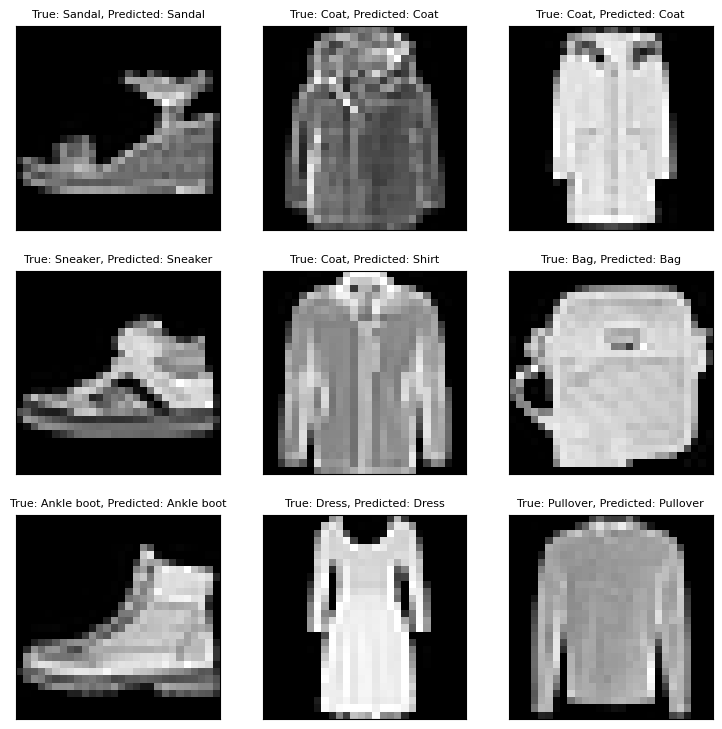

In [17]:
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
with torch.no_grad():
    for ax in axs.flat:
        idx = np.random.randint(len(test_loader.dataset))
        image, true_label = test_loader.dataset[idx]

        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        ax.imshow(image.view(28, 28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {test_loader.dataset.classes[true_label]}, Predicted: {test_loader.dataset.classes[predicted.item()]}'
                     , fontsize=8)

plt.show()

#### Матрица ошибок и точность на тесте

Test Accuracy: 89.26%


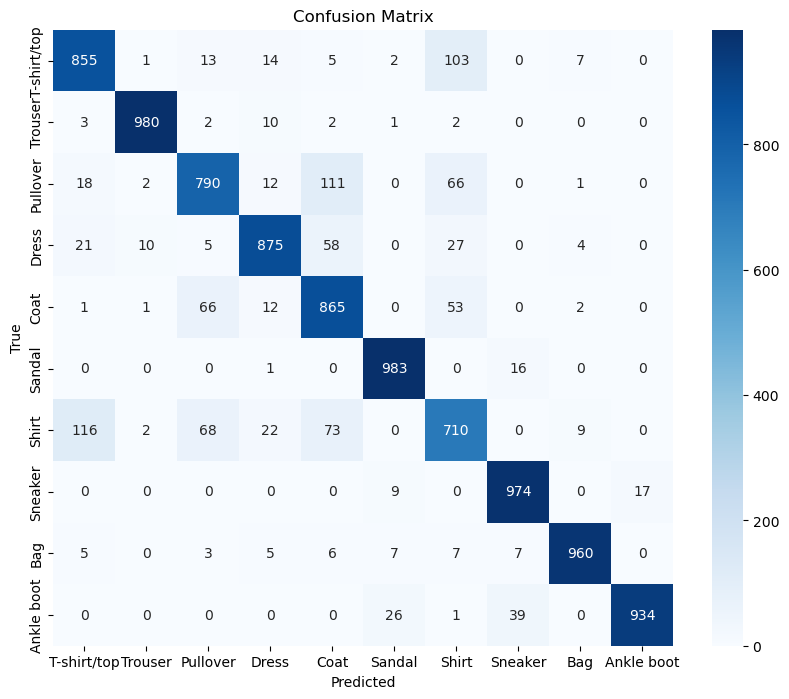

In [18]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

correct = (np.array(true_labels) == np.array(predicted_labels)).sum()
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.2%}")

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Сохранение модели

In [19]:
torch.save(model.state_dict(), "modelFashionMNIST_NN.pth")

## 1.2 Решить задачу 1.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 90%
* Визуализировать результаты работы первого сверточного слоя

### Архитектура модели 

In [26]:
# Параметры модели:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

### Загрузка данных

In [27]:
# обязательно используем shuffle так как у нашего датасет есть порядок
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST(root="./data/", train=True, download=True,
                             transform=
                               torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST(root="./data/", train=False, download=True,
                             transform=
                               torchvision.transforms.ToTensor()),
  batch_size=batch_size_train, shuffle=True)

### Модель 

In [28]:
class FashionMNIST_CNN(nn.Module):
    
    def __init__(self):
        super(FashionMNIST_CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            
            # nn.Conv2d  - сверточный слой. Он принимает входные изображения с одним каналом (предполагается, что вы работаете с изображениями в оттенках серого) и выполняет свертку с 32 фильтрами размером 3x3. Результатом свертки является набор карт признаков (feature maps).
            # in_channels=1 - один канал цвета
            # out_channels=32 - каналов признака
            # kernel_size=3 -  ядро(окно) свертки имеет размер 3x3
            # padding=1 - вокруг входных данных добавляется один пиксель нулей. Это называется "нулевым" (zero) заполнением.
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            
            # nn.BatchNorm2d(32) - это слой нормализации по батчу (Batch Normalization) для 2D данных. 
            # В данном случае, это применяется к 2D признаковым картам (feature maps), которые создаются после сверточного слоя с out_channels=32.
            # Каждый канал признаков нормализуется путем вычитания среднего и деления на стандартное отклонение.
            # Cтабильное и быстрое обучение нейронных сетей, уменьшение вероятности переобучения и улучшение обобщающей способности модели
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d - слой представляет операцию пулинга с окном размером 2x2 и шагом 2. 
            # Пулинг выполняет уменьшение размера признаковых карт, усредняя (или выбирая максимальное значение) в каждом окне размером 2x2 и перемещая его на 2 пикселя вниз и вправо.
            # kernel_size=2 - окно 2x2
            # stride=2 - шаг окна 
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # nn.Dropout2d(0.25) -  25% нейронов в этом слое будут выключены случайным образом во время обучения
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

#### Количество параметров модели

In [29]:
model = FashionMNIST_CNN()
print('Количество параметров модели: ', sum(p.numel() for p in model.parameters()))

Количество параметров модели:  1475338


#### Обучение модели

In [30]:
model = FashionMNIST_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer , criterion, n_epochs, train_loader, test_loader )

FashionMNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)
Epoch [0/5], Loss: 0.3070, Test Accuracy: 88.04%
Epoch [1/5], Loss: 0.1818, Test Accuracy: 90.02%
Epoch [2/5], Loss: 0.2063, Test Accuracy: 89.67%
Epoch [3/5], Loss: 0.3631, Test Accur

### Вывод первого слоя 

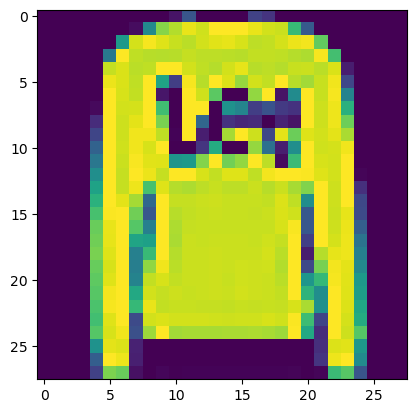

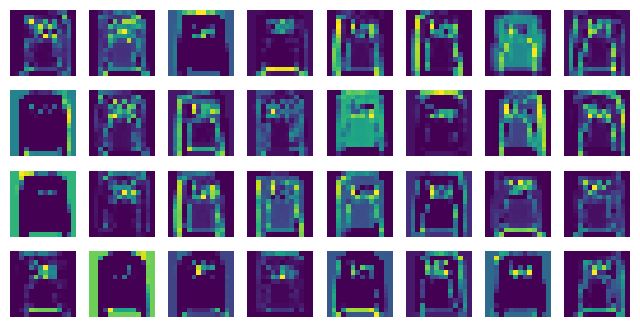

In [31]:
image, true_label = test_loader.dataset[1]

plt.imshow(image.permute(1, 2, 0).numpy())
plt.show()



image = image.unsqueeze(0) # добавляем размерость, так как наша нейронка принимает батчи
conv1 = model.layer1(image)

plt.figure(figsize=(8, 4))
for i in range(conv1.size(1)): 
    plt.subplot(4, 8, i + 1)
    conv1_output = conv1[0, i].detach().numpy() 
    plt.imshow(conv1_output, cmap='viridis')
    plt.axis('off')

plt.show()


#  2. Классификация изображений (датасет CIFAR 10) 


## 2.1 Решить задачу классификации, не используя сверточные слои. 

* Нормализовать данные (если необходимо)
* Предложить архитектуру модели для решения задачи
* Посчитать количество параметров модели.
* Обучить модель
* Вывести график функции потерь по эпохам. 
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
* Сохранить модель

### Архитектура модели 

In [32]:
# Параметры модели:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

### Загрузка данных

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [34]:
# обязательно используем shuffle так как у нашего датасет есть порядок
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10(root="./data/", train=True, download=True,
                             transform= transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10(root="./data/", train=False, download=True,
                             transform=transform),
  batch_size=batch_size_train, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Анализ датасета

In [35]:
print("Количество примеров в обучающем наборе данных:",  len(train_loader.dataset))
print("Количество примеров в тестовом наборе данных:", len(test_loader.dataset))


Количество примеров в обучающем наборе данных: 50000
Количество примеров в тестовом наборе данных: 10000


In [36]:
print("Количество batch в обучающем наборе данных:",  len(train_loader))
print("Количество batch в тестовом наборе данных:", len(test_loader))

Количество batch в обучающем наборе данных: 782
Количество batch в тестовом наборе данных: 157


In [37]:
def show_img(img):
    img = img / 2 + 0.5 
    img_np = img.numpy()
    
    plt.imshow(np.transpose(img_np, (1,2,0)))
    plt.show()
    

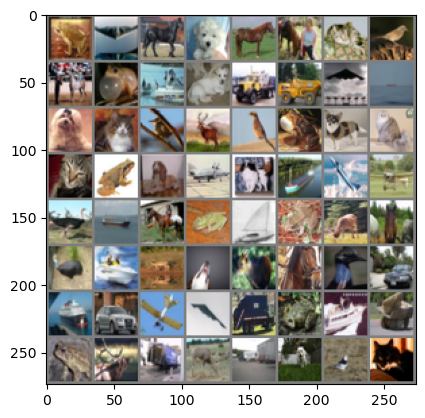

In [38]:
detaiter = iter(train_loader)
images,labels = next(detaiter)

show_img(torchvision.utils.make_grid(images))

In [39]:
train_loader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Модель

In [40]:
class CIFAR10_NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], hidden_size[2])
        self.fc4 = nn.Linear(hidden_size[2], num_classes)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        out = self.tanh(out)
        out = self.fc4(out)
        return out
    

#### Количество параметров модели

In [41]:
model = CIFAR10_NN(3072, [500, 500, 500], 10)
print('Количество параметров модели: ', sum(p.numel() for p in model.parameters()))

Количество параметров модели:  2042510


#### Обучение модели

In [44]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train(model, optimizer, criterion, n_epochs, train_loader, test_loader)

Epoch [0/20], Loss: 1.5947, Test Accuracy: 46.49%
Epoch [1/20], Loss: 1.9565, Test Accuracy: 49.29%
Epoch [2/20], Loss: 1.3226, Test Accuracy: 49.75%
Epoch [3/20], Loss: 1.3923, Test Accuracy: 50.66%
Epoch [4/20], Loss: 1.0043, Test Accuracy: 51.79%
Epoch [5/20], Loss: 1.2528, Test Accuracy: 52.63%
Epoch [6/20], Loss: 1.5085, Test Accuracy: 50.95%
Epoch [7/20], Loss: 1.2464, Test Accuracy: 52.45%
Epoch [8/20], Loss: 0.9380, Test Accuracy: 52.30%
Epoch [9/20], Loss: 0.9158, Test Accuracy: 52.11%
Epoch [10/20], Loss: 1.1072, Test Accuracy: 51.79%
Epoch [11/20], Loss: 1.2932, Test Accuracy: 53.19%
Epoch [12/20], Loss: 0.8550, Test Accuracy: 52.84%
Epoch [13/20], Loss: 0.9393, Test Accuracy: 53.32%
Epoch [14/20], Loss: 0.8100, Test Accuracy: 52.75%
Epoch [15/20], Loss: 1.4076, Test Accuracy: 53.08%
Epoch [16/20], Loss: 0.8310, Test Accuracy: 53.00%
Epoch [17/20], Loss: 0.9554, Test Accuracy: 53.28%
Epoch [18/20], Loss: 1.2514, Test Accuracy: 53.64%
Epoch [19/20], Loss: 0.5836, Test Accurac

#### Работа модели

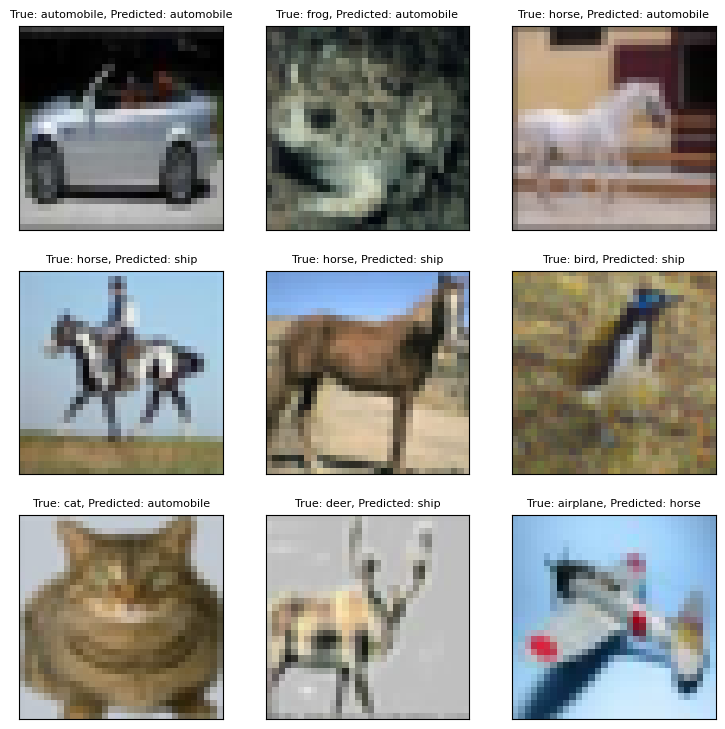

In [43]:
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
with torch.no_grad():
    for ax in axs.flat:
        idx = np.random.randint(len(test_loader.dataset))
        image, true_label = test_loader.dataset[idx]

        outputs = model(image.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)

        
        ax.imshow(np.transpose(image, (1, 2, 0)) / 2 + 0.5 , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {test_loader.dataset.classes[true_label]}, Predicted: {test_loader.dataset.classes[predicted.item()]}'
                     , fontsize=8)

plt.show()

#### Матрица ошибок и точность на тесте

Test Accuracy: 52.25%


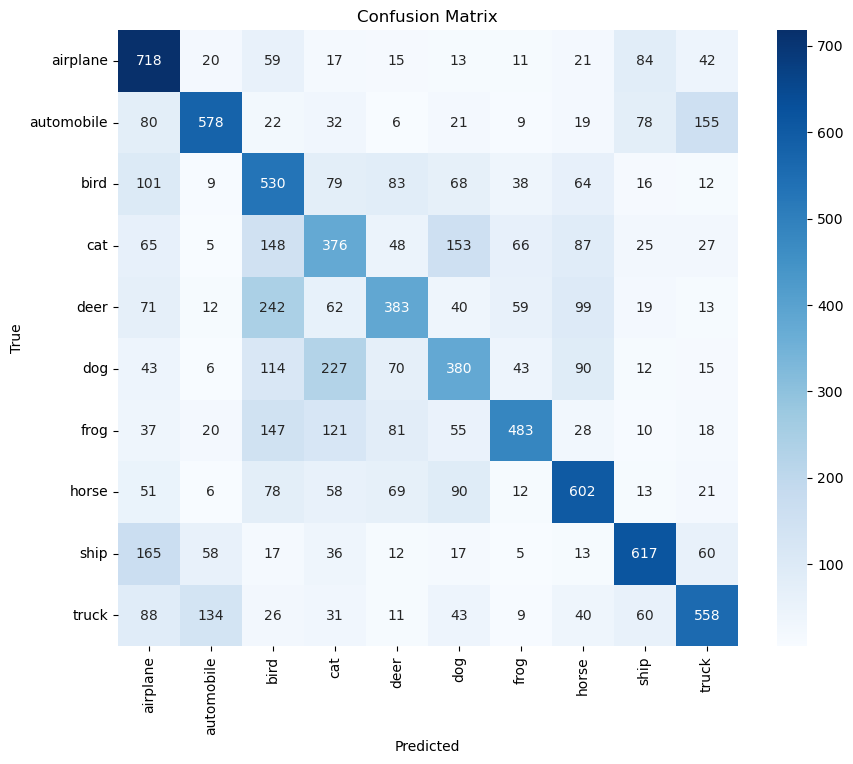

In [45]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.shape[0], -1) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

correct = (np.array(true_labels) == np.array(predicted_labels)).sum()
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.2%}")

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Сохранение модели

In [46]:
torch.save(model.state_dict(), "modelCIFAR10_NN.pth")

## 2.2 Решить задачу 2.1, используя сверточную нейронную сеть. 
* Добиться значения accuracy на тестовом множестве не менее 70%.
* Визуализировать результаты работы первого сверточного слоя

### Архитектура модели 

In [47]:
# Параметры модели:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001

In [48]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

### Загрузка данных

In [49]:
# обязательно используем shuffle так как у нашего датасет есть порядок
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10(root="./data/", train=True, download=True,
                             transform= transform),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10(root="./data/", train=False, download=True,
                             transform=transform),
  batch_size=batch_size_train, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Модель

In [54]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
     
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#### Количество параметров модели

In [55]:
model = CIFAR10_CNN()
print('Количество параметров модели: ', sum(p.numel() for p in model.parameters()))

Количество параметров модели:  422410


#### Обучение модели

In [56]:
model = CIFAR10_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, test_loader)

CIFAR10_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [0/20], Loss: 1.2276, Test Accuracy: 61.39%
Epoch [1/20], Loss: 1.1344, Test Accuracy: 68.65%
Epoch [2/20], Loss: 1.3059, Test Accuracy: 67.61%
Epoch [3/20], Loss: 1.1309, Test Accuracy: 69.44%
Epoch [4/20], Loss: 0.6554, Test Accuracy: 70.91%
Epo

### Вывод первого слоя 

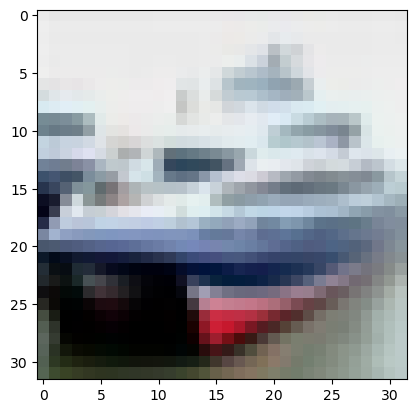

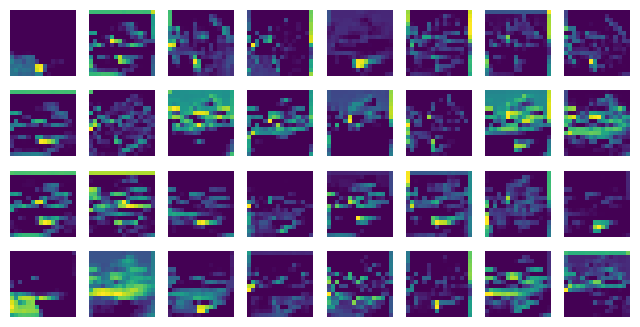

In [58]:
image, true_label = test_loader.dataset[1]

plt.imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
plt.show()

image = image.unsqueeze(0) # добавляем размерость, так как наша нейронка принимает батчи
conv1 = model.layer1(image)

plt.figure(figsize=(8, 4))
for i in range(conv1.size(1)): 
    plt.subplot(4, 8, i + 1)
    conv1_output = conv1[0, i].detach().numpy() 
    plt.imshow(conv1_output, cmap='viridis')
    plt.axis('off')

plt.show()

# 3. Загрузка изображений из внешних источников

### 3.1 Решить задачу классификации обезьян (датасет [monkey.zip](https://disk.yandex.ru/d/OxYgY4S7aR6ulQ)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 60%

#### Архитектура модели

In [59]:
# Параметры модели:
n_epochs = 5
batch_size_train = 64
batch_size_valid = 1000
learning_rate = 0.001

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Загрузка архива

In [61]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('monkeys.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file, 'monkeys') # to folder monkey

100%|██████████████████████████████████████| 1371/1371 [00:01<00:00, 853.59it/s]


#### Создание датасета

In [62]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [63]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("monkeys/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [64]:
train_dataset = torchvision.datasets.ImageFolder(root='monkeys/training/training',  transform = train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root='monkeys/validation/validation', transform = valid_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size_valid, shuffle=False,
)

In [65]:
train_loader.dataset.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [66]:
valid_loader.dataset[2]

(tensor([[[ 0.6000,  0.5216,  0.5373,  ...,  0.1843,  0.1294,  0.1137],
          [ 0.5529,  0.5373,  0.5294,  ...,  0.0510,  0.0118,  0.0667],
          [ 0.5373,  0.5608,  0.5686,  ..., -0.0275, -0.0431,  0.0431],
          ...,
          [-0.0980, -0.1294, -0.1373,  ..., -0.5686, -0.5686, -0.5843],
          [-0.0980, -0.1137, -0.1137,  ..., -0.4196, -0.4275, -0.4431],
          [-0.0980, -0.0980, -0.1059,  ..., -0.3569, -0.3961, -0.4196]],
 
         [[ 0.4824,  0.3961,  0.4745,  ...,  0.3647,  0.3725,  0.3647],
          [ 0.4196,  0.4039,  0.4353,  ...,  0.2784,  0.2471,  0.2706],
          [ 0.3961,  0.4196,  0.4510,  ...,  0.2078,  0.2235,  0.2941],
          ...,
          [ 0.1922,  0.1843,  0.1765,  ..., -0.2627, -0.2627, -0.2549],
          [ 0.2078,  0.2157,  0.2078,  ..., -0.1216, -0.1294, -0.1216],
          [ 0.2157,  0.2235,  0.2157,  ..., -0.0745, -0.0902, -0.0745]],
 
         [[ 0.2000,  0.0667,  0.0196,  ..., -0.0196, -0.0196, -0.0039],
          [ 0.1373,  0.0667,

#### Модель

In [71]:
class Monkey_CNN(nn.Module):
    def __init__(self):
        super(Monkey_CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
     
        )

        self.fc1 = nn.Linear(64 * 99 * 99, 128)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

In [72]:
model = Monkey_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, valid_loader)

Monkey_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=627264, out_features=128, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [0/5], Loss: 72.2646, Test Accuracy: 24.26%
Epoch [1/5], Loss: 38.5785, Test Accuracy: 40.44%
Epoch [2/5], Loss: 40.5225, Test Accuracy: 54.78%
Epoch [3/5], Loss: 0.0002, Test Accuracy: 61.76%
Epoch [4/5], Loss: 14.1939, Test Accuracy: 65.07%


#### Работа модели

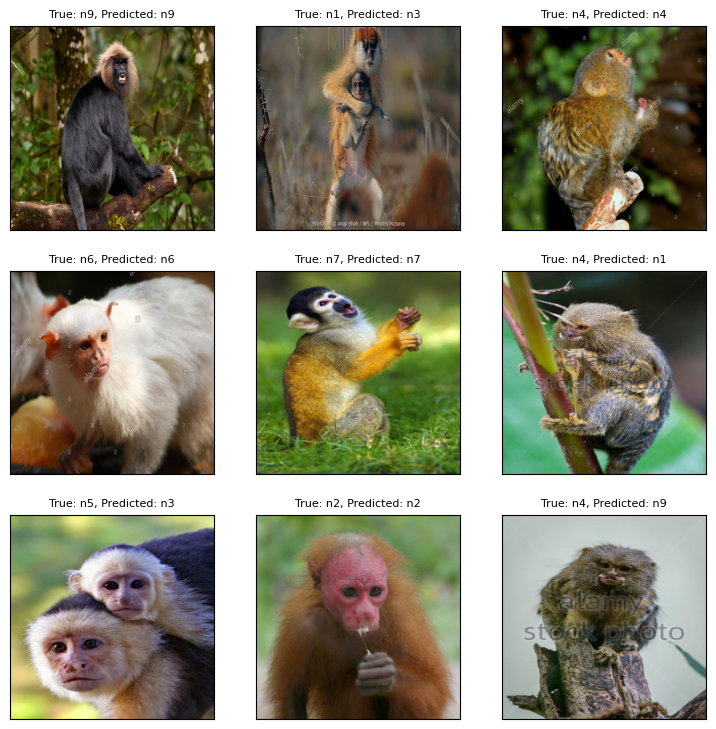

In [73]:
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
with torch.no_grad():
    for ax in axs.flat:
        idx = np.random.randint(len(valid_loader.dataset))
        image, true_label = valid_loader.dataset[idx]

        outputs = model(image.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)

        
        ax.imshow(np.transpose(image, (1, 2, 0)) / 2 + 0.5 , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {valid_loader.dataset.classes[true_label]}, Predicted: {valid_loader.dataset.classes[predicted.item()]}'
                     , fontsize=8)

plt.show()

#### Матрица ошибок и точность на тесте

Test Accuracy: 65.07%


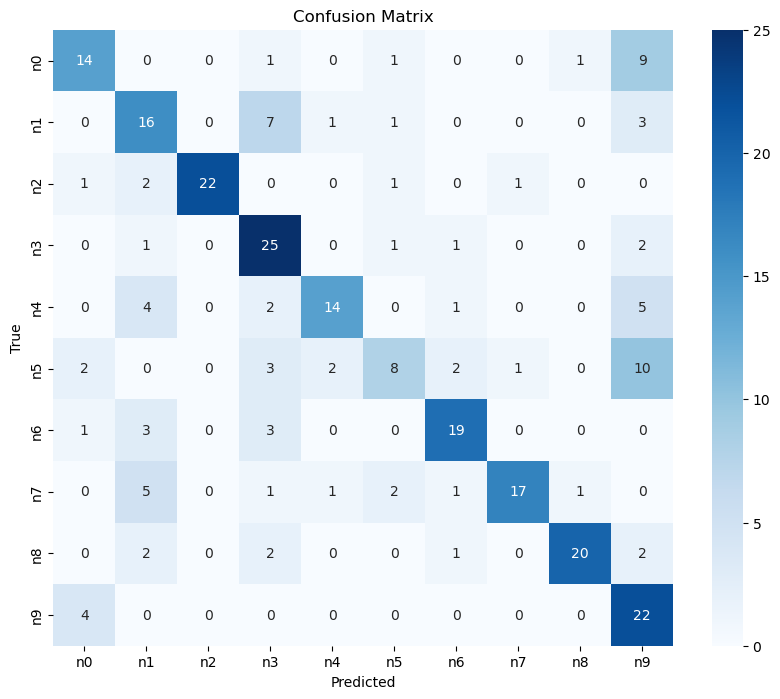

In [74]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in valid_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

correct = (np.array(true_labels) == np.array(predicted_labels)).sum()
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.2%}")

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=valid_loader.dataset.classes, yticklabels=valid_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### 3.2 Решить задачу классификации собак и кошек (датасет [cats_dogs.zip](https://disk.yandex.ru/d/wQtt5O1JF9ctnA)).
* Загрузить архив с данными на диск
* Создать датасет на основе файлов при помощи `torchvision.datasets.ImageFolder`
* Преобразовать изображения к тензорами одного размера (например, 400х400). Потестировать другие преобразования из `torchvision.transforms`
* Предложить архитектуру модели для решения задачи. Обучить модель.
* Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy на тестовом множестве.
  * Добиться значения accuracy на тестовом множестве не менее 80%

#### Архитектура модели

In [75]:
# Параметры модели:
n_epochs = 10
batch_size_train = 64
batch_size_valid = 1000
learning_rate = 0.001

In [76]:
# from google.colab import drive
# drive.mount('/content/drive')

#### Загрузка архива

In [77]:
import zipfile
from tqdm import tqdm

zf = zipfile.ZipFile('cats_dogs.zip')
for file in tqdm(zf.infolist()):
    zf.extract(file, 'cats_dogs') 

100%|███████████████████████████████████| 25004/25004 [00:05<00:00, 4602.43it/s]


#### Создание датасета

In [ ]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# # the validation transforms
# valid_transform = transforms.Compose([
#     transforms.Resize((400, 400)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5, 0.5, 0.5],
#         std=[0.5, 0.5, 0.5]
#     )
# ])

In [ ]:
ls

In [78]:
train_dataset = torchvision.datasets.ImageFolder(root='cats_dogs_train',  transform = train_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(root='cats_dogs_test',  transform = train_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size_train, shuffle=False
)

#### Модель

In [ ]:
class CatsDogs_CNN(nn.Module):
    def __init__(self):
        super(CatsDogs_CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(288, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)

        return x

In [ ]:
model = CatsDogs_CNN()
print('Количество параметров модели: ', sum(p.numel() for p in model.parameters()))

In [120]:
model = CatsDogs_CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, test_loader)

CatsDogs_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=320000, out_features=128, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)
Батч 0
Батч 5
Батч 10
Батч 15
Epoch [0/10], Loss: 0.8283, Test Accuracy: 41.75%
Батч 0
Батч 5
Батч 10
Батч 15
Epoch [1/10], Loss: 0.6295, Test Accuracy: 53.47%
Батч 0
Батч 5
Батч 10
Батч 15
Epoch [2/10], Loss: 0.6984, Test Accuracy: 58.25%
Батч 0
Батч 5
Батч 10
Батч 15
Epoch [3/10], Loss: 0.6307, Test Accuracy: 57.42%
Батч 0
Батч 5
Батч 10
Батч 15
Epoc

[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:110] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

#### Работа модели

In [ ]:
model.eval()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
with torch.no_grad():
    for ax in axs.flat:
        idx = np.random.randint(len(test_loader.dataset))
        image, true_label = test_loader.dataset[idx]

        outputs = model(image.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)

        
        ax.imshow(np.transpose(image, (1, 2, 0)) / 2 + 0.5 , cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'True: {test_loader.dataset.classes[true_label]}, Predicted: {test_loader.dataset.classes[predicted.item()]}'
                     , fontsize=8)

plt.show()

#### Матрица ошибок и точность на тесте

In [ ]:
true_labels = []
predicted_labels = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

correct = (np.array(true_labels) == np.array(predicted_labels)).sum()
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.2%}")

confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 4. Transfer Learning

### 4.1 Решить задачу 3.1, воспользовавшись предобученной моделью VGG16
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель (не замораживать веса). Вычислить значение accuracy на тестовом множестве
* Дообучить модель (заморозить все веса, кроме последнего блока слоев (`classifier`)). 
* Вычислить значение accuracy на тестовом множестве.


#### Архитектура модели

In [121]:
# Параметры модели:
n_epochs = 10
batch_size_train = 64
batch_size_valid = 1000
learning_rate = 0.001

In [122]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [123]:
train_dataset = torchvision.datasets.ImageFolder(root='monkeys/training/training',  transform = train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root='monkeys/validation/validation', transform = valid_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size_valid, shuffle=False,
)

In [124]:
model = torchvision.models.vgg16(pretrained=True)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/kirillanpilov/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|████████████████████████████████████████| 528M/528M [00:21<00:00, 25.6MB/s]


### Без заморозки

In [125]:
num_classes = len(train_dataset.classes) 
model.classifier[6] = nn.Linear(4096, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, valid_loader)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1


KeyboardInterrupt



### С замарозкой

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, valid_loader)

### 4.2 Решить задачу 3.2, воспользовавшись подходящей предобученной моделью
* Не использовать VGG16 (вместо нее можно взять resnet18 или другую)
* Загрузить данные для обучения
* Преобразования: размер 224x224, нормализация с параметрами `mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)`
* Заменить последний полносвязный слой модели в соответствии с задачей
* Дообучить модель. 
* Вычислить значение accuracy на тестовом множестве (добиться значения не меньше 97-98%)

#### Архитектура модели

In [75]:
# Параметры модели:
n_epochs = 10
batch_size_train = 64
batch_size_valid = 1000
learning_rate = 0.001

#### Создание датасета

In [ ]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

# the validation transforms
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    )
])

In [ ]:
ls

In [78]:
train_dataset = torchvision.datasets.ImageFolder(root='cats_dogs_train',  transform = train_transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size_train, shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(root='cats_dogs_test',  transform = test_transform)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size_train, shuffle=False
)

In [ ]:
model = torchvision.models.vgg16(pretrained=True)

### Без заморозки

In [ ]:
model.classifier[6] = nn.Linear(4096, 2)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, test_dataset)

### С замарозкой

In [ ]:
for param in model.features.parameters():
    param.requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier[6].parameters(), lr=learning_rate)
print(model)
train(model, optimizer, criterion, n_epochs, train_loader, test_dataset)